# RAW File Loading

In [15]:
import os
import numpy as np
import cv2

from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader

## Opening a File

Opening a RAW or DAT file is as easy as creating a new `RawReader` or `EventDatReader` passing the path of the file.
Printing the created object will show some metadata about the reading status, such as the current index time and position.

Note how RAW files and DAT files contain different metadata.

In [16]:
input_path_raw = "spinner.raw"
input_path_dat = "spinner.dat"
# if the file doesn't exist, it will be downloaded from Prophesee's public sample server 
from metavision_core.utils import get_sample

get_sample(input_path_raw, folder=".")
get_sample(input_path_dat, folder=".")

Here is an example of openning a RAW file.


In [17]:
# open a file
record_raw = RawReader(input_path_raw)
print(record_raw)  # show some metadata

RawReader(spinner.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 100000000


Here is an example of openning a DAT file.


In [18]:
record_dat = EventDatReader(input_path_dat)
print(record_dat)

DatReader: spinner.dat
-----------
Event Type: EventCD
Event Size: 8 bytes
Event Count: 54165303
Duration: 5.002329 s 
-----------



## Getting the Events

Now that the reader is created, we can get the events. This is done in the same way for both RAW and DAT files. Here we show an example using the RAW file, but the same can be done using the DAT file.

There are two ways to read events: 

* by number of events, using the `load_n_events()` function
* by time slices, using the `load_delta_t()` function


In [19]:
events = record_raw.load_n_events(10)  # load the 10 next events
events_by_time = record_raw.load_delta_t(10000)  # load the next 10ms of data

print(events)

[(237, 121, 1, 0) (246, 121, 1, 0) (248, 132, 1, 0) (239, 133, 1, 0)
 (256, 134, 1, 0) (248, 135, 1, 0) (238, 129, 1, 1) (239, 129, 1, 1)
 (258, 129, 1, 1) (250, 128, 1, 1)]


Events are stored in a numpy [structured array](https://numpy.org/doc/stable/user/basics.rec.html). This means you can conveniently access each attribute of the events ($x$,$y$, polarity $p$ and timestamp $t$) as a numpy array. It also allows to use native numpy operators such as [slicing](https://numpy.org/devdocs/user/basics.indexing.html?highlight=slice#combining-index-arrays-with-slices) or [boolean masking](https://numpy.org/devdocs/user/basics.indexing.html?highlight=slice#boolean-or-mask-index-arrays)

In [20]:
# we can access different fields in this one dimensional array
print(events['t'])  # this shows only the timestamps of events
# for instance, to count the events of positive polarity you can do:
np.sum(events['p'] == 1)

[0 0 0 0 0 0 1 1 1 1]


10

In [21]:
# let's randomly select some events
np.random.choice(events, len(events)//2)

array([(250, 128, 1, 1), (250, 128, 1, 1), (248, 132, 1, 0),
       (248, 135, 1, 0), (248, 135, 1, 0)],
      dtype={'names':['x','y','p','t'], 'formats':['<u2','<u2','<i2','<i8'], 'offsets':[0,2,4,8], 'itemsize':16})

## Iteration

The two functions `load_n_events()` and `load_delta_t()` can be used to read all events in a file using a `while` loop.

In [22]:
sums = 0
#  load 10M events by batches of 50ms:
while not record_raw.is_done() and record_raw.current_event_index() < 1E7:
    # load the next 50 ms worth of events
    events = record_raw.load_delta_t(50000)
    sums += events.size
print("Event count: {}".format(sums))
print(record_raw)

Event count: 10333420
RawReader(spinner.raw)
current time : 960001us done : False
current event index : 10443584
_begin_buffer 10443584,_end_buffer_ 10881430,  buffer_size 100000000


You can restart from the beginning by calling the `reset` function. Note how all attributes are reset, and the event timestamps are the same as the first ones above.

In [23]:
#   record_raw.reset()
#   print(record_raw)

## Visualization

We can visualize events using a function that will prepare an image from the numpy array of events.

Then we can display this image using standard visualization tools, such as [Matplotlib](<https://matplotlib.org/>).

In [24]:

def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img


True

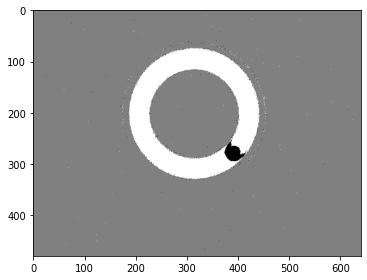

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots

height, width = record_raw.get_size()

# load the next 50 ms worth of events
events = record_raw.load_delta_t(500000)
im = viz_events(events, height, width)

plt.imshow(im)
plt.tight_layout()
cv2.imwrite('circle.jpg',im)

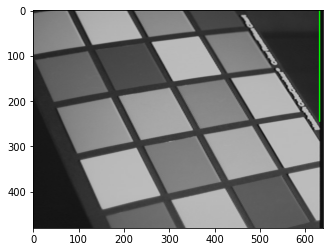

In [12]:
# This is a test attempt at a still from basic hough transform (not working)
img = cv2.imread('img01.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imwrite('houghlines.jpg',img)
plt.imshow(img)


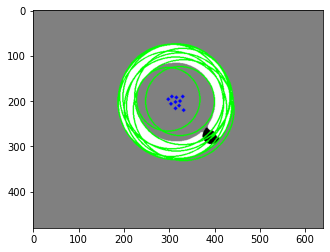

In [33]:
# Test attempt at circular hough transform
# Initial tests reveal several semi-cencentric circles along all polarity net change, not current frame change

# to get a single 'time frame' load next 10 ms of data together and build an image like this

img1 = cv2.imread('circle.jpg',0)
img1 = cv2.medianBlur(img1,9)
cimg = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img1,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',cimg)
plt.imshow(cimg)


In [14]:
img1

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]], dtype=uint8)

True

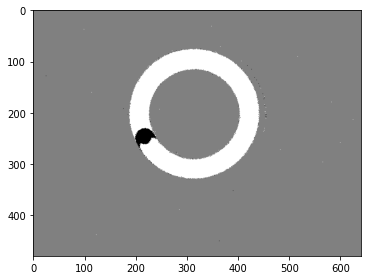

In [30]:
#attempt 2 circle hough

height, width = record_raw.get_size()

#  iteration
# load 10M events by batches of 50ms:
while not record_raw.is_done() and record_raw.current_event_index() < 1E7:
    # load the next 50 ms worth of events
    events = record_raw.load_delta_t(50000)
    
    im = viz_events(events, height, width)
    img1 = cv2.medianBlur(img1,9)
    cimg = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img1,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)



plt.imshow(im)
plt.tight_layout()
cv2.imwrite('circle.jpg',im)